In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *
import os

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from networkx import from_dict_of_lists, Graph, adjacency_matrix, dfs_postorder_nodes
from networkx.algorithms import node_connected_component

os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5')
dm.set_gabor_params(gabor_params_id='blueNisslWide')
dm.set_segmentation_params(segm_params_id='blueNisslRegular')
dm.set_vq_params(vq_params_id='blueNissl')

In [43]:
dm.set_slice(1)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'npy')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
# each item is (center_y, center_x, area, mean_intensity, ymin, xmin, ymax, xmax)
segmentation_vis = dm.load_pipeline_result('segmentationWithoutText', 'jpg')

In [71]:
from joblib import load, dump
_ = dump(neighbors, '/tmp/tmp')
large_memmap = load('/tmp/tmp', mmap_mode='r+')

ValueError: Array can't be memory-mapped: Python objects in dtype.

In [44]:
try:
    sp_sp_dists = dm.load_pipeline_result('texHistPairwiseDist', 'npy')
#     raise
except:
    def f(a):
        sp_dists = cdist(a, texton_hists, metric=chi2)
#         sp_dists = cdist(a, texton_hists, metric=js)
        return sp_dists

    sp_dists = Parallel(n_jobs=16)(delayed(f)(s) for s in np.array_split(texton_hists, 16))
    sp_sp_dists = np.vstack(sp_dists)
    
    dm.save_pipeline_result(sp_sp_dists, 'texHistPairwiseDist', 'npy')

center_dists = pdist(sp_properties[:, :2])
center_dist_matrix = squareform(center_dists)

neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)

In [45]:
# roughly the frequency texton counts (unnormalized histogram)
texton_freqs = texton_hists * sp_properties[:,2][:, np.newaxis]

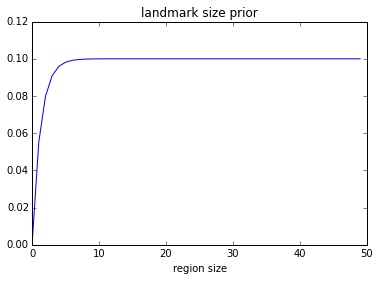

In [6]:
# size prior
x = np.arange(0,50,1)
plt.plot(.1 * (1-np.exp(-.8*x)));
plt.xlabel('region size');
plt.title('landmark size prior');

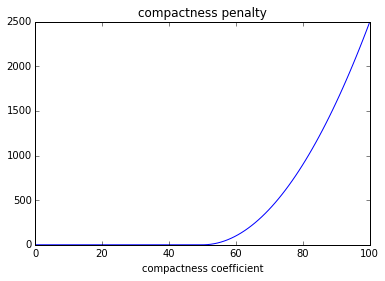

In [7]:
# compactness penalty
x = np.linspace(0,100,100)
y = np.maximum(x-50,0)**2
plt.plot(x,y);
plt.xlabel('compactness coefficient');
plt.title('compactness penalty');

In [46]:
def find_boundary_sps(clusters, neighbors, neighbor_graph, mode=None):
    '''
    Identify superpixels that are at the boundary of regions: surround set and frontier set
    
    Parameters
    ----------
    clusters : list of integer lists
    neighbors : neighbor_list
    neighbor_graph : 
    '''
        
    n_superpixels = len(clusters)
    
    surrounds_sps = []
    frontiers_sps = []
    
    for cluster_ind, cluster in enumerate(clusters):
        
        surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
        surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

        if len(surrounds) == 0:
            surrounds_sps.append([])
            frontiers_sps.append([])

        else:
            
            if mode == 'surrounds' or mode == 'both':
                surrounds_subgraph = neighbor_graph.subgraph(surrounds)
                surrounds_traversal = list(dfs_postorder_nodes(surrounds_subgraph))
                surrounds_sps.append(surrounds_traversal)
            
            if mode == 'frontiers' or mode == 'both':
                frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)
                frontiers_subgraph = neighbor_graph.subgraph(frontiers)
                frontiers_traversal = list(dfs_postorder_nodes(frontiers_subgraph))
                frontiers_sps.append(frontiers_traversal)            
    
    if mode == 'surrounds':
        return surrounds_sps
    elif mode == 'frontiers':
        return frontiers_sps
    else:
        return surrounds_sps, frontiers_sps

In [47]:
def compute_cluster_score(cluster, texton_hists=texton_hists, neighbors=neighbors):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
    surround_dist = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2)).min()

    surds = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph,
                                    mode='surrounds')
    
    compactness = len(surds[0])**2/float(len(cluster))
    compactness = .001 * np.maximum(compactness-40,0)**2
    
    size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
    score = surround_dist - compactness + size_prior
    
    interior_dist = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    
    return score, surround_dist, interior_dist, compactness, surround_pval, interior_pval, size_prior

In [10]:
# def compute_cluster_score(cluster, texton_hists=texton_hists, neighbors=neighbors, output=False):
#     '''
#     Computes the significance score of a cluster
    
#     '''
    
#     cluster_list = list(cluster)
#     cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
#     surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
#     surrounds_list = list(surrounds)

# #     f_avg = texton_freqs[cluster_list].sum(axis=0)
    
# #     interior_pvals = [chi2pval(f_avg, texton_freqs[i])[0] for i in cluster_list]
# #     interior_pval = np.mean(interior_pvals)
#     interior_pval = 0

# #     surround_pvals = [chi2pval(f_avg, texton_freqs[i])[0] for i in surrounds_list]
# #     surround_pval = np.max(surround_pvals)
#     surround_pval = 0
# #     assert not np.isnan(surround_pval), (cluster_list, surrounds_list[where(np.isnan(surround_pvals))[0]])

#     interior_dist = np.squeeze(cdist([cluster_avg], texton_hists[cluster_list], chi2)).mean()
#     surround_dist = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2)).min()

# #     surround_stats = [chi2pval(f_avg, texton_freqs[i])[1] for i in surrounds_list]
# #     surround_stat = np.min(surround_stats) 
    
# #     compactness = 0
#     compactness = len(find_boundaries([cluster], neighbors=neighbors, mode='surrounds')[0])**2/float(len(cluster))
#     compactness = .001 * np.maximum(compactness-40,0)**2
    
#     size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
# #     score = 0. * surround_dist - interior_dist -  .0001 * np.maximum(compactness-50,0)**2
# #     score = - surround_pval + interior_pval
# #     score = - interior_dist
# #     score = surround_dist - 0 * interior_dist - compactness
# #     score = - surround_pval - 0 * interior_dist - compactness + size_prior
#     score = surround_dist - 0 * interior_dist - compactness + size_prior
    
# #     return score, surround_pval, interior_pval, compactness
#     return score, surround_dist, interior_dist, compactness, surround_pval, interior_pval, size_prior
# #     return score, surround_stat, interior_dist, compactness


In [48]:
def grow_cluster3(seed, neighbors=neighbors, texton_hists=texton_hists, output=False, all_history=False):
            
    visited = set([])
    curr_cluster = set([])
        
    candidate_scores = [0]
    candidate_sps = [seed]

    score_tuples = []
    added_sps = []
    
    iter_ind = 0
        
    while len(candidate_sps) > 0:

        best_ind = np.argmax(candidate_scores)
        
        heuristic = candidate_scores[best_ind]
        sp = candidate_sps[best_ind]
        
        del candidate_scores[best_ind]
        del candidate_sps[best_ind]
        
        if sp in curr_cluster:
            continue
                
        iter_ind += 1
        curr_cluster.add(sp)
        added_sps.append(sp)
        
        tt = compute_cluster_score(curr_cluster, neighbors=neighbors, texton_hists=texton_hists)
        tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt
        if np.isnan(tot):
            return [seed], -np.inf
        score_tuples.append(np.r_[heuristic, tt])
        
        if output:
            print 'iter', iter_ind, 'add', sp

        visited.add(sp)
        
        candidate_sps = (set(candidate_sps) | (neighbors[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster
        candidate_sps = list(candidate_sps)
        
#         f_avg = texton_freqs[list(curr_cluster)].sum(axis=0)
#         candidate_scores = [chi2pval(f_avg, texton_freqs[i])[0] for i in candidate_sps]

        h_avg = texton_hists[list(curr_cluster)].mean(axis=0)
        candidate_scores = [-chi2(h_avg, texton_hists[i]) for i in candidate_sps]

#         candidate_scores = [compute_cluster_score(curr_cluster | set([s])) for s in candidate_sps]
                
        if len(visited) > int(n_superpixels * 0.03):
            break

    score_tuples = np.array(score_tuples)
    
    min_size = 2
    scores = score_tuples[:,1]
    cutoff = np.argmax(scores[min_size:]) + min_size
    
    if output:
        print 'cutoff', cutoff

    final_cluster = added_sps[:cutoff]
    final_score = scores[cutoff]
    
    if all_history:
        return list(final_cluster), final_score, added_sps, score_tuples
    else:
        return list(final_cluster), final_score

In [ ]:
%prun final_cluster, final_score = grow_cluster3(2783, neighbors=neighbors, texton_hists=texton_hists)

In [ ]:
display(dm.visualize_cluster(final_cluster, text=True))

In [ ]:
# Plot the score evolution during region growing

final_cluster, final_score, added_sps, score_tuples = grow_cluster3(2783, neighbors=neighbors, 
                                                        texton_hists=texton_hists, output=False, all_history=True)

print 'final_score', final_score
print 'cutoff', score_tuples[:,1].argmax()

fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True)
# axes[0].plot(score_tuples[:,0])
# axes[0].set_title('heuristic')
axes[0].plot(score_tuples[:,1])
axes[0].set_title('total sig')
axes[1].plot(score_tuples[:,2])
axes[1].set_title('min chi-square contrast')
axes[2].plot(score_tuples[:,3])
axes[2].set_title('mean chi-square incoherence')
axes[3].plot(score_tuples[:,4])
axes[3].set_title('compactness')
# axes[5].plot(score_tuples[:,5])
# axes[5].set_title('max exterior p-value')
# axes[6].plot(score_tuples[:,6])
# axes[6].set_title('mean interior p-value')
# axes[7].plot(score_tuples[:,7])
# axes[7].set_title('size_prior')

# fig, axes = plt.subplots(8,1, figsize=(10,10), sharex=True)
# axes[0].plot(score_tuples[:,0])
# axes[0].set_title('heuristic')
# axes[1].plot(score_tuples[:,1])
# axes[1].set_title('total sig')
# axes[2].plot(score_tuples[:,2])
# axes[2].set_title('min chi-square contrast')
# axes[3].plot(score_tuples[:,3])
# axes[3].set_title('mean chi-square incoherence')
# axes[4].plot(score_tuples[:,4])
# axes[4].set_title('compactness')
# axes[5].plot(score_tuples[:,5])
# axes[5].set_title('max exterior p-value')
# axes[6].plot(score_tuples[:,6])
# axes[6].set_title('mean interior p-value')
# axes[7].plot(score_tuples[:,7])
# axes[7].set_title('size_prior')

plt.tight_layout()
plt.show()

In [49]:
from scipy.stats import chisquare, chisqprob
vars = np.var(texton_freqs, axis=0)

def chi2pval(O1, O2):
    n1 = O1.sum()
    n2 = O2.sum()
    n = n1 + n2
    nc = O1 + O2
    E1 = n1/n*nc
    E2 = n2/n*nc
    v = np.nonzero((O1 > 0) &  (O2 > 0) & (vars > 0))[0]
    if len(v) == 0:
        return 1e-6, np.nan
    dof = max(len(v)-1, 1)
    q = np.sum((O1[v]-E1[v])**2/vars[v]+(O2[v]-E2[v])**2/vars[v])
    return chisqprob(q, dof), q

In [51]:
try:
    expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
#     raise
except Exception as e:

    import time
    b = time.time()

    expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster3)(s) for s in range(n_superpixels))

#     expansion_clusters_tuples = []
#     for s in range(n_superpixels):
#         print s
#         ect = grow_cluster3(s)
#         expansion_clusters_tuples.append(ect)
    
    print time.time() - b

    dm.save_pipeline_result(expansion_clusters_tuples, 'clusters', 'pkl')

In [52]:
# expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
expansion_cluster_scores = np.array(expansion_cluster_scores)

# Region Clustering Experiments

In [53]:
def compute_overlap(c1, c2):
    return float(len(c1 & c2)) / min(len(c1),len(c2))

def compute_overlap2(c1, c2):
    return float(len(c1 & c2)) / len(c1 | c2)    

def compute_overlap_partial(indices, sets, metric=1):
    n_sets = len(sets)
    
    overlap_matrix = np.zeros((len(indices), n_sets))
        
    for ii, i in enumerate(indices):
        for j in range(n_sets):
            c1 = set(sets[i])
            c2 = set(sets[j])
            if len(c1) == 0 or len(c2) == 0:
                overlap_matrix[ii, j] = 0
            else:
                if metric == 1:
                    overlap_matrix[ii, j] = compute_overlap(c1, c2)
                elif metric == 2:
                    overlap_matrix[ii, j] = compute_overlap2(c1, c2)
            
    return overlap_matrix

def set_pairwise_distances(sets, metric):

    partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
                                        for s in np.array_split(range(len(sets)), 16))
    overlap_matrix = np.vstack(partial_overlap_mat)
    distance_matrix = 1 - overlap_matrix
    
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix

def group_clusters(clusters=None, dist_thresh = 0.1, distance_matrix=None, metric=1):

    if distance_matrix is None:
        assert clusters is not None
        distance_matrix = set_pairwise_distances(clusters, metric)
        
    lk = average(squareform(distance_matrix))
#     lk = single(squareform(distance_matrix))

    # T = fcluster(lk, 1.15, criterion='inconsistent')
    T = fcluster(lk, dist_thresh, criterion='distance')

    n_groups = len(set(T))    
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]
        
    return [g for g in groups if len(g) > 0]

In [54]:
try:
    D = dm.load_pipeline_result('clusterPairwiseDist', 'npy')
#     raise
except:
    D = set_pairwise_distances(expansion_clusters, metric=2)
    dm.save_pipeline_result(D, 'clusterPairwiseDist', 'npy')

In [55]:
try:
    expansion_cluster_groups = dm.load_pipeline_result('clusterGroups', 'pkl')
#     raise
except:
    
    import time
    t = time.time()
    expansion_cluster_groups = group_clusters(expansion_clusters, dist_thresh=.8, distance_matrix=D)
    dm.save_pipeline_result(expansion_cluster_groups, 'clusterGroups', 'pkl')

    print time.time() - t
    
print len(expansion_cluster_groups), 'expansion cluster groups'
expansion_cluster_group_sizes = np.array(map(len, expansion_cluster_groups))

523 expansion cluster groups


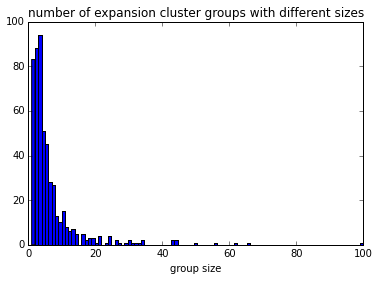

In [61]:
plt.hist(expansion_cluster_group_sizes, bins=100);
plt.xlabel('group size');
plt.title('number of expansion cluster groups with different sizes');

In [62]:
big_group_indices = np.where(expansion_cluster_group_sizes > 5)[0]
n_big_groups = len(big_group_indices)
print n_big_groups, 'big cluster groups'
big_groups = [expansion_cluster_groups[i] for i in big_group_indices]

# representative_cluster_indices = [g[np.argmax(expansion_cluster_scores[g])] for g in big_groups]
# representative_cluster_scores = [expansion_cluster_scores[ind] for ind in representative_cluster_indices]

# representative_cluster_scores_sorted, representative_cluster_indices_sorted_by_score, big_groups_sorted_by_score = map(list, 
#                                                                 zip(*sorted(zip(representative_cluster_scores, 
#                                                                     representative_cluster_indices,
#                                                                     big_groups), reverse=True)))

# representative_clusters_sorted_by_score = [expansion_clusters[i] for i in representative_cluster_indices_sorted_by_score]

162 big cluster groups


In [63]:
from collections import Counter

representative_clusters = []
representative_cluster_scores = []
representative_cluster_indices = []

big_groups_valid = []

for gi, g in enumerate(big_groups):
#     counter = Counter([frozenset(expansion_clusters[s]) for s in g])
#     representative_cluster = counter.keys()[np.argmax(counter.values())]
#     representative_clusters.append(representative_cluster)
        
#     cluster_indices_sorted_by_score = g[np.argsort(expansion_cluster_scores[g])[-1]]
    
    # Choose the highest scoring expansion cluster among each group as the representatitve
    for i in np.argsort(expansion_cluster_scores[g])[::-1]:
        c = expansion_clusters[g[i]]
        sc = expansion_cluster_scores[g[i]]
        if len(c) > n_superpixels * .004:
            # threshold on region size, must have more than certain number of sp. (roughly 16 for 4,000 sps)
            # this may exclude some small but salient regions
            representative_clusters.append(c)
            representative_cluster_indices.append(g[i])
            representative_cluster_scores.append(sc)
            big_groups_valid.append(g)
            break
    
            
#     score_counter = Counter(expansion_cluster_scores[g])
#     representative_cluster_score = score_counter.keys()[np.argmax(score_counter.values())]
#     representative_cluster_scores.append(representative_cluster_score)
    
# Note that representative_clusters and big_groups have different number of elements
    
print len(representative_clusters), 'representative clusters'
    
representative_cluster_scores_sorted, representative_clusters_sorted_by_score, \
representative_cluster_indices_sorted_by_score, \
big_groups_sorted_by_score = map(list, zip(*sorted(zip(representative_cluster_scores, 
                                                        representative_clusters,
                                                        representative_cluster_indices,
                                                        big_groups_valid), reverse=True)))

64 representative clusters


In [68]:
for i, e in enumerate(representative_clusters_sorted_by_score):
    if 2355 in e:
        print i

33


In [66]:
display(dm.visualize_multiple_clusters(representative_clusters_sorted_by_score[40:50]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [52]:
representative_clusters = zip(representative_cluster_scores_sorted, representative_clusters_sorted_by_score, 
                   representative_cluster_indices_sorted_by_score, 
                   big_groups_sorted_by_score)

dm.save_pipeline_result(representative_clusters, 'representativeClusters', 'pkl')

saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_representativeClusters.pkl


In [50]:
final_clusters_sorted_by_score = representative_clusters_sorted_by_score[:50]
final_cluster_scores_sorted = representative_cluster_scores_sorted[:50]
final_cluster_indices_sorted_by_score = representative_cluster_indices_sorted_by_score[:50]

In [ ]:
final_clusters_sorted_by_score = []
final_cluster_scores_sorted = []
final_cluster_indices_sorted_by_score = []

covered = set([])

for c, s, i in zip(representative_clusters_sorted_by_score, 
                   representative_cluster_scores_sorted, 
                   representative_cluster_indices_sorted_by_score)[:40]:
        
    if len(covered & set(c)) > 15:
        print i, 'overlaps %d superpixels with previously selected regions' % len(covered & set(c))
        continue

    covered |= set(c)
    final_clusters_sorted_by_score.append(c)
    final_cluster_scores_sorted.append(s)
    final_cluster_indices_sorted_by_score.append(i)

In [51]:
vis = visualize_multiple_clusters(final_clusters_sorted_by_score[:10], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop10' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[:20], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop20' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[:30], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop30' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[:40], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop40' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[10:20], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop10to20' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[20:30], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop20to30' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[30:40], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop30to40' , 'jpg')

vis = visualize_multiple_clusters(final_clusters_sorted_by_score[40:], segmentation=segmentation, segmentation_vis=segmentation_vis)
dm.save_pipeline_result( vis, 'regionsTop40toX' , 'jpg')


#     fig = plt.figure(figsize=(10,10))
#     plt.imshow(vis)
#     plt.title('sorted group ' + str(i) + ', score ' + str(s))
#     plt.axis('off')
#     plt.show()

saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop20.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop30.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop40.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop10to20.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_regionsTop20to30.jpg
saved /home/yuncong/project/DavidData2014results/RS141/0007/RS141_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-

In [ ]:
# def SaveFigureAsImage(fileName,fig=None,orig_size=None):

#     dpi = fig.get_dpi()
#     w,h = orig_size
#     fig.set_size_inches([float(w/dpi), float(h/dpi)])

#     a=fig.gca()
#     a.set_frame_on(False)
#     a.set_xticks([]); a.set_yticks([])
#     plt.axis('off')
#     plt.xlim(0,h); plt.ylim(w,0)
#     fig.savefig(fileName, transparent=True, bbox_inches='tight', \
#                         pad_inches=0)
    
    
# def SaveFigureAsImage(fileName,fig=None,**kwargs):
#     ''' Save a Matplotlib figure as an image without borders or frames.
#        Args:
#             fileName (str): String that ends in .png etc.

#             fig (Matplotlib figure instance): figure you want to save as the image
#         Keyword Args:
#             orig_size (tuple): width, height of the original image used to maintain 
#             aspect ratio.
#     '''
#     fig_size = fig.get_size_inches()
#     dpi = fig.get_dpi()
    
#     fig.set_size_inches(dpi)
    
#     w,h = fig_size[0], fig_size[1]
#     fig.patch.set_alpha(0)
#     if kwargs.has_key('orig_size'): # Aspect ratio scaling if required
#         w,h = kwargs['orig_size']
#         w2,h2 = fig_size[0],fig_size[1]
#         fig.set_size_inches([(w2/w)*w,(w2/w)*h])
#         fig.set_dpi((w2/w)*fig.get_dpi())
#     a=fig.gca()
#     a.set_frame_on(False)
#     a.set_xticks([]); a.set_yticks([])
#     plt.axis('off')
#     plt.xlim(0,h); plt.ylim(w,0)
#     fig.savefig(fileName, transparent=True, bbox_inches='tight', \
#                         pad_inches=0)

In [ ]:
# colors = (np.loadtxt('../visualization/100colors.txt') * 255).astype(np.int)

# def visualize_contours(clusters):

#     vis = dm.image_rgb.copy()

#     for ci, c in enumerate(clusters):
#         q = np.zeros((n_superpixels,))
#         q[c] = 1.
#         v = q[segmentation]
#         contours = find_contours(img_as_float(v), 0.8)
#         contour = contours[np.argmax(map(len, contours))]
#         contour = np.round(contour[:,::-1].reshape((-1,1,2))).astype(np.int)
#         cv2.polylines(vis, [contour], isClosed=True, color=colors[ci%len(colors)], thickness=10) 
#     #     cv2.polylines(vis, [contour], isClosed=True, color=[237,194,136], thickness=5) 

#     #     ax.plot(contour[:,1], contour[:,0])

#     # fig.savefig('tmp.png', bbox_inches='tight', pad_inches=0)
#     # fig.savefig('tmp.png', pad_inches=0)
#     # SaveFigureAsImage('tmp.png', fig, orig_size=dm.image.shape[:2])
#     # FileLink('tmp.png')
#     return vis

# # dm.save_pipeline_result(representative_clusters_sorted_by_score, 'goodRegions', 'pkl')

# vis = visualize_contours(final_clusters_sorted_by_score[:10])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop10', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[10:20])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop10to20', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[20:30])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop20to30', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[30:])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop30to40', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score)
# dm.save_pipeline_result(np.uint8(vis), 'contoursTopAll', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[:20])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop20', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[:30])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop30', 'jpg')

# vis = visualize_contours(final_clusters_sorted_by_score[:40])
# dm.save_pipeline_result(np.uint8(vis), 'contoursTop40', 'jpg')

In [ ]:
# display(visualize_contours(representative_clusters_sorted_by_score[10:20]))